# Practice 5: Ligand classification model

## Introduction
Machine learning has established itself as an essential component in data science, enabling computers to learn from data and make decisions or predictions without being cleanly programmed to do so. Within this framework, an algorithm of particular importance is the *RandomForest* classification model.

<img src="./img/random_forest.png" width="600" align='right'>

The RandomForest model is a supervised learning algorithm that is based on the ensemble method. This method combines several weaker algorithms to form a more powerful and robust model. In the case of RandomForest, a "forest" of *decision trees* is created, each perturbing on a random subset of the data. The end result is the combination of the predictions from all these individual trees.

RandomForest is characterized by being versatile and efficient, capable of handling a large number of features and addressing both classification and regression problems. One of the advantages of this algorithm is that it provides a measure of the importance of the variables, offering valuable information about the model and the data.

### Validation Strategy: K-fold Cross Validation

Model validation is a crucial step in the development of any machine learning algorithm. Its purpose is to evaluate how well the learned model can generalize to unseen data, that is, it was not used during the training phase. In our practice, we will employ the K-Fold cross-validation strategy.

<img src="./img/K-fold_Cross_Validation.png" width="500" align='left'>

K-Fold cross validation is a powerful and widely used technique that improves model performance estimation. Instead of dividing the data set once into a training set and a test set, K-Fold cross-validation divides the data set into 'K' distinct subsets. The algorithm is then trained 'K' times, each time using a different subset as the test set and the rest of the subsets as the training set. Finally, the performance of the model is averaged over the 'K' iterations to obtain a more robust estimate.

The goal is to test the model's ability to predict previously unseen data, detect problems such as overfitting, and assess the generalizability of the model.


### Performance measures

The choice of performance measures depends on the nature of the problem being addressed. However, there are some common measures that are often useful in evaluating the performance of classification models. To understand and calculate these performance measures, it helps to know their formulas. Before providing the formulas, it is important to note that they are based on the concepts of True Positives (**TP**), False Positives (**FP**), True Negatives (**TN**), and False Negatives (**FN**), which are the four possible categories into which the predictions of our model can be classified. The confusion matrix is useful to differentiate each concept:

<img src="./img/confusion_matrix.png" width="400">

* **Accuracy**: It is the proportion of correct predictions among the total number of predictions made. Although it is an intuitive and easy to understand measure, the accuracy can be misleading if the classes are unbalanced. Accuracy is calculated as the sum of the correct predictions (both positive and negative) divided by the total predictions.
    $$Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN}$$

* **Precision (Precision)**: It is the proportion of positive predictions that were correct. It is a useful measure when false positives are of particular concern. Precision is calculated as the number of true positives divided by the sum of true positives and false positives.
    $$Precision = \dfrac{TP}{TP+FP}$$

* **Recall (Sensitivity)**: It is the proportion of real positive cases that the model correctly identified. It is important when false negatives are a concern. The recall is calculated as the number of true positives divided by the sum of true positives and false negatives.
    $$Remember = TP/(TP + FN)$$

* **F1 Score (F1 Score)**: It is the harmonic mean of precision and recall. This measure seeks a balance between precision and recall. The F1 score is calculated as the harmonic average of precision and recall.
    $$F1_{score} = 2 \times \dfrac{Precision \times Recall}{Precision + Recall}$$

* **ROC curve (Receiver Operating Characteristic)**: This curve is a graphical representation that illustrates the discriminative capacity of a binary classifier as its discrimination threshold varies. It is created by plotting the true positive rate (Recall) against the false positive rate (1-Specificity), at various threshold levels. A model with perfect predictive power would be located in the upper left corner of the graph, while a random model would follow the diagonal line.

* **AUC (Area Under the Curve)**: This metric is calculated as the area under the ROC curve. An AUC of 1.0 denotes a perfect pattern, while an AUC of 0.5 denotes a pattern that has no discriminatory ability, equivalent to a random selection. The higher the AUC, the better the model will be at distinguishing between the positive and negative classes.

In our analysis of the implementation of the RandomForest model, we will use these measures to assess its performance and generalizability.

# Data preparation
We start by importing the data from the previous lab, as these are stored in the folder of the second part, we can create a `root directory` (`ROOT_DIR`) to navigate to the file and load it into a dataframe

## Data loading

In [1]:
# Libraries needed to import the saved database
import pandas as pd
import os
from pathlib import Path

current_directory = os.getcwd()
ROOT_DIR = Path(current_directory).parent
uniprot_id = 'P49841'
print('Directorio raíz:', ROOT_DIR)
df_output = pd.read_csv(f'{ROOT_DIR}/2_PART_TWO/data/compounds_P49841_lipinski.csv')
df_output.head()

Directorio raíz: E:\Users\Aleja\Documents\GitHub\CHEMO


,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,392.196074,8,0,1.9610,yes


In this exercise we only need the ligands that comply with the *rule of five*, therefore, we must filter by the column: `rule_of_five_conform:yes`. Also, we only need the first three columns

In [2]:
print(f'# total ligands: {len(df_output)}')
df_output = df_output[df_output['rule_of_five_conform']=='yes']
df_output = df_output[['molecule_chembl_id', 'pchembl_value', 'smiles']]
print(f'# filtered ligands (rule_of_five_conform:yes): {len(df_output)}')

df_output.head()

# total ligands: 2657
# filtered ligands (rule_of_five_conform:yes): 2477


,molecule_chembl_id,pchembl_value,smiles
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...


## Data processing
### Molecular Fingerprints

To train our algorithm, it is necessary to convert the ligands into a list of features. Currently, we have the molecular structure (SMILES) of each ligand, and with this information we can generate an alternative representation known as *fingerprint*. This representation will be used later to train the model.

To identify and generate the fingerprints of each ligand, we will use the `rdkit` library. This operation will result in the creation of a new column in our data set that will contain the fingerprint of each ligand. There are several types of fingerprints, but this time we will work with the [Extended Connectivity Fingerprint ECFP](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md) also known as morgan2_c/ecfp4 .

In [3]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
df_fp = df_output.copy()
df_fp['morgan2_c'] = df_output.smiles.map(lambda smile: rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2).ToList())
df_fp = df_fp[['molecule_chembl_id', 'morgan2_c', 'pchembl_value']]
df_fp.head()

,molecule_chembl_id,morgan2_c,pchembl_value
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70


Let's explore the first fingerprint: a binary list (ones and zeros) with a length of 2048 elements. These fingerprint elements will be the features that will be used to train the model.

In [4]:
print(df_fp.morgan2_c[0])
print(len(df_fp.morgan2_c[0]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Classification of ligands

Each ligand must be classified as **active** or **inactive**, for this we will use the `pIC50` column defining activity thresholds
The protein *Glycogen synthase kinase-3 beta* is classified in the group of *Kinases*, therefore, we will use the following thresholds:
**Inactive**: *pchem_value* < 6.52 uM
**Active**: **pchem_value* >= 7.52 uM

In [5]:
# Remove unnecessary columns
# Add column for activity, default = internet
df_fp['activity_type'] = 'Intermediate'
# Mark each molecule as active with a pIC50 >= 7.52
df_fp.loc[df_fp[df_fp.pchembl_value >= 7.5].index, 'activity_type'] = 'Active'
# Mark each molecule as inactive with a pIC50 of < 6.52
df_fp.loc[df_fp[df_fp.pchembl_value < 6.52].index, 'activity_type'] = 'Inactive'
df_fp.head()

,molecule_chembl_id,morgan2_c,pchembl_value,activity_type
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


Let's see graphically how the classification was

activity_type
Inactive        1178
Intermediate     676
Active           623
Name: count, dtype: int64


<Axes: xlabel='activity_type'>

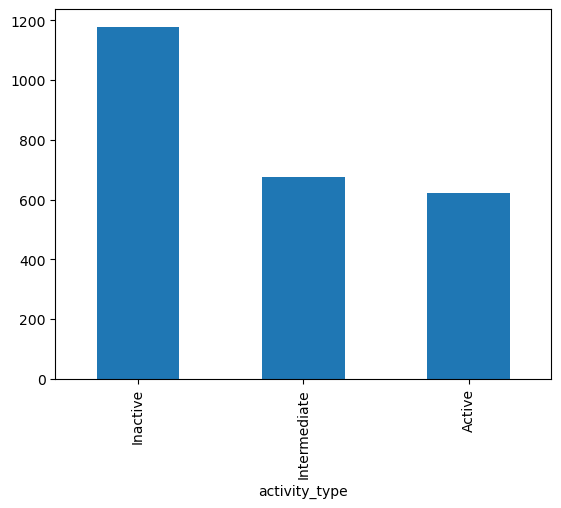

In [6]:
print(df_fp.activity_type.value_counts())
df_fp.activity_type.value_counts().plot.bar(x='activity_type')

Now we filter the data removing those that are classified as *Intermediate*

# ligandos (active/inactive): 1801
activity_type
Inactive    1178
Active       623
Name: count, dtype: int64


,molecule_chembl_id,morgan2_c,pchembl_value,activity_type
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


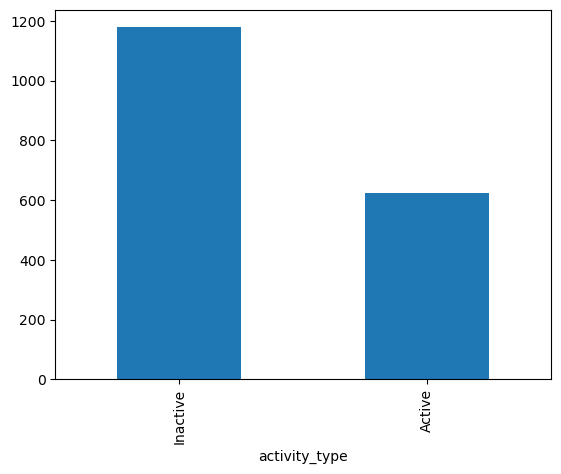

In [7]:
bd = df_fp[df_fp['activity_type'] != 'Intermediate'].copy()
bd.activity_type.value_counts().plot.bar(x='activity_type')
print(f'# ligandos (active/inactive): {len(bd)}')
print(bd.activity_type.value_counts())
bd.head()

Since it is a binary classification, we must assign a label: (Inactive:0 / Active:1)

In [8]:
bd['activity'] = 0
bd.loc[bd[bd.activity_type == 'Active'].index, 'activity'] = 1.0
bd.drop(['activity_type', 'pchembl_value'], axis=1, inplace=True)
bd.head()

,molecule_chembl_id,morgan2_c,activity
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


We already have the features (morgan2_c fingerprint) and tags (activity) to be able to train the model

# Train the model with the *Random Forest* algorithm

We are going to train a Random Forest model that classifies ligands knowing the fingerprint. The goal is to test the model's ability to predict data that has never been seen before, to detect problems known as overfitting, and to assess the generalizability of the model.

### Random Forest
Usually, the first step is to **split** the data set, one part for training (70%) and the other part for testing (30%).

In [9]:
from sklearn.model_selection import train_test_split
fp_df_train, fp_df_test = train_test_split(bd, test_size=0.3, random_state=142857,
                                             shuffle=True, stratify=bd['activity'])
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_test.reset_index(drop=True, inplace=True)
print(f'# training data: {len(fp_df_train)},'
       f'\n# test data: {len(fp_df_test)}')

# training data: 1260,
# test data: 541


Now, for each set we are going to separate the characteristics (the fingerprint) and the label

In [11]:
X_train, y_train = fp_df_train.morgan2_c, fp_df_train.activity
X_test, y_test = fp_df_test.morgan2_c, fp_df_test.activity
# The array of features should be converted to a list of items
X_train, X_test = X_train.tolist(), X_test.tolist()

We choose the estimator of [Random Fores classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to train the model, the model must be instantiated and built

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Validation
### Accuracy score

There are several metrics to measure the ability of the model to make predictions, let's see an example using the metric [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score)

The first thing is to classify (*predict*) the data from the set and then compare it with the true labels, we will do this with both the **training set** and the **test set**:

In [13]:
from sklearn.metrics import accuracy_score
# Prediction training set
y_train_pred = model.predict(X_train)
# prediction set validation
y_test_pre = model.predict(X_test)

# Punctuation
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pre)
print(f'Accuracy training set: {acc_train:.4f} ({acc_train:.2%})\n'
       f'Accuracy test set: {acc_test:.4f} ({acc_test:.2%})')

Accuracy training set: 1.0000 (100.00%)
Accuracy test set: 0.8799 (87.99%)


El *accuracy* del conjunto de entrenamiento es del 100%, lo cual indica un caso de *Overfitting*, posiblemente se deba hacer un ajuste de los parámetros del modelo de clasificación o incluso utilizar otro modelo.

### Confusion Matrix
With this matrix you can compare the true labels versus the model predictions, [here](https://en.wikipedia.org/wiki/Confusion_matrix) you can see more information about the confusion matrix. In this case we are going to compare the data from the validation set:

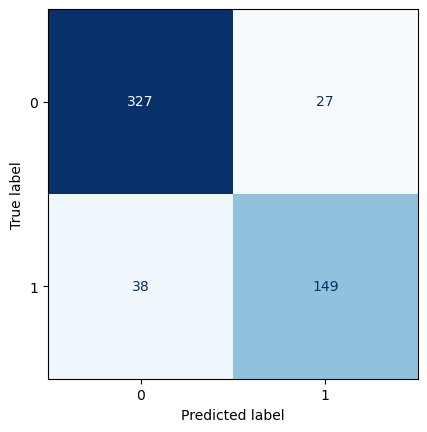

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,  cmap=plt.cm.Blues)

You can work with the normalized data to see it as a percentage

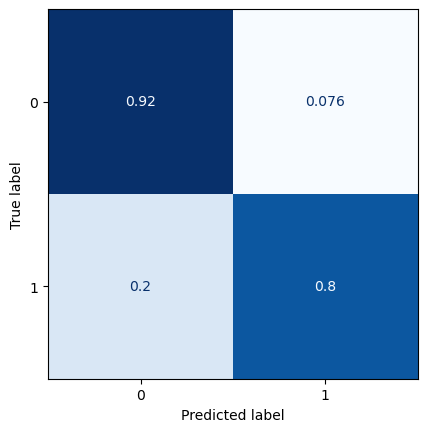

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

### ROC curve
The ROC curve (ROC curve, Receiver Operating Characteristic) is a graphical representation of the sensitivity versus the specificity for a binary classifier system as the discrimination threshold is varied, it is usually used to represent how good the model is, let's see how you can build one:

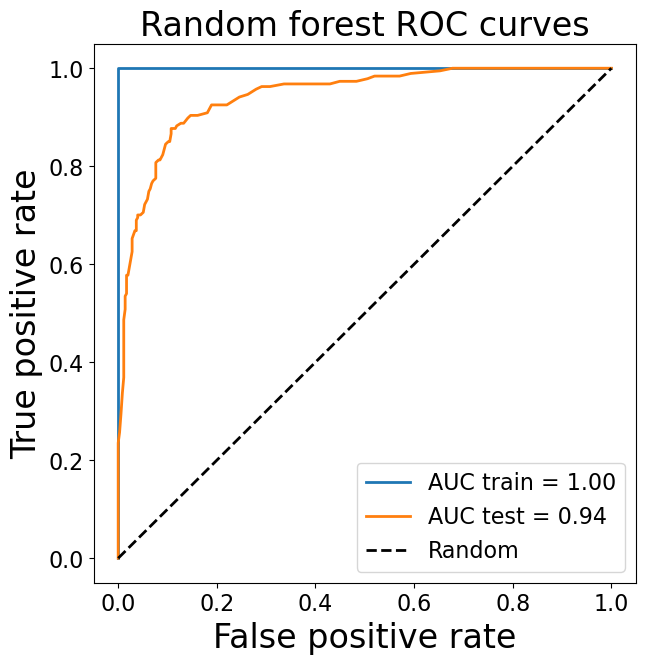

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib as mpl
import matplotlib.pyplot as plt

# Probability of predictions
pred_prob_train = model.predict_proba(X_train)[:, 1]
pred_prob_test = model.predict_proba(X_test)[:, 1]

# false positive rates / true positive rates - training
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
# false positive rates / true positive rates - test
fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)
plt.plot(fpr_test, tpr_test, label=f'AUC test = {roc_auc_test:.2f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black") # Random curve

plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

### K-fold (cross validation)

We are going to divide the data into 5 sets, each one of them will train the algorithm and measure its predictive capacity, then the data from the five models will be contrasted to validate if the trained model works or not.

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

n_folds = 5
# empty result vector
results = []
# Shuffle the indices for k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True)
# Labels initialized with -1 for each data point
labels = -1 * np.ones(len(bd))
# instance model
model = RandomForestClassifier()

for train_index, test_index in kf.split(bd):
    # Training
    # Converts the bit vector and the label to a list
    train_x = bd.iloc[train_index].morgan2_c.tolist()
    train_y = bd.iloc[train_index].activity.tolist()

    # fit the model
    model.fit(train_x, train_y)

    # Evidence
    # Converts the bit vector and the label to a list
    test_x = bd.iloc[test_index].morgan2_c.tolist()
    test_y = bd.iloc[test_index].activity.tolist()
    # Predict on test set
    prediction_prob = model.predict_proba(test_x)[:, 1]
    # Save the predicted label of each fold
    labels[test_index] = model.predict(test_x)

    # performance
    # Get fpr, tpr and roc_auc for each fold
    fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
    roc_auc_l = auc(fpr_l, tpr_l)
    # Add to results
    results.append((fpr_l, tpr_l, roc_auc_l))
# Get overall accuracy, sensitivity, specificity
y = bd.activity.tolist()
acc = accuracy_score(y, labels)
sens = recall_score(y, labels)
spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))

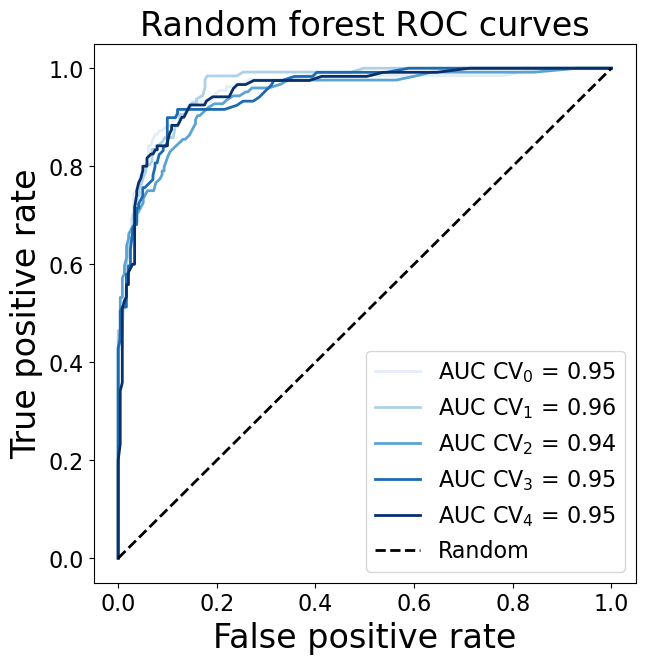

In [20]:
plt.figure(figsize=(7, 7))
cmap = mpl.colormaps['Blues']
colors = [cmap(i) for i in np.linspace(0.1, 1.0, n_folds)]

for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(results):
    plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title(f'Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

plt.show()

In [21]:
# Calculate the mean AUC and print
m_auc = np.mean([elem[2] for elem in results])
print(f'Mean AUC: {m_auc:.3f}')

# show overall precision, sensitivity, specificity
print(f'Sensitivity: {sens:.3f}\nAccuracy: {acc:.3f}\nSpecificity: {spec:.3f}')

Mean AUC: 0.953
Sensitivity: 0.783
Accuracy: 0.883
Specificity: 0.936


## Conclusions
The Random Forest classification algorithm is exceptionally powerful for performing binary classifications. In the case of our study, this involved classifying molecules as active or inactive. However, our initial implementation of the model revealed a significant overfitting of the data. This phenomenon suggests that the algorithm tries to capture all the characteristics of the molecules instead of achieving an effective generalization. Overfitting can lead to low predictability for molecules that are not part of the training set, a scenario we would prefer to avoid.

## Practice Activity
To decrease the overfitting problem, you can change the [model parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), which regulate how the training is carried out. As a practical activity, you are invited to experiment with the modification of these parameters and to compare the results obtained. Can you find a set of parameters that will reduce overfitting and improve the overall performance of the model? How do these changes affect different performance metrics? Explore and share your findings.

# Machine Learning XGBoost

An alternative to the overfitting problem is to explore the use of a different classification model to train our algorithm. This time, we decided to implement XGBoost, an efficient and sophisticated machine learning software library based on the decision tree boosting algorithm.

XGBoost, which stands for eXtreme Gradient Boosting, is known for its speed and performance. It is an algorithm that has proven valuable in a variety of data science competitions and has been widely adopted in the industry. As a boosting algorithm, XGBoost is based on the idea of creating a strong predictive model by combining a series of weaker models, iteratively improving the predictions of the ensemble.

## Model training

In this practice we are going to train a model with some parameters established in advance, which improve the default model.

In [29]:
import xgboost as xgb
xgbc_model = xgb.XGBClassifier()
# training parameters
params = {'objective': 'binary:logistic', 'early_stopping_rounds': 20,
           'enable_categorical': False, 'eval_metric': ['error', 'auc'],
           'gamma': 0.2, 'gpu_id': 0, 'grow_policy': 'depthwise',
           'learning_rate': 0.32, 'max_depth': 7,
           'min_child_weight': 1, 'n_estimators': 100,
           'scale_pos_weight': 3.271, 'subsample': 0.8, 'tree_method': 'gpu_hist',
           'alpha': 0.2, 'lambda': 1.4}
xgbc_model.set_params(**params)

XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['error', 'auc'],
              feature_types=None, gamma=0.2, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None, lambda=1.4,
              learning_rate=0.32, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

To train the XGBoost model it is necessary to generate a validation set to use the "early stopping" functionality of XGBoost. "Early stopping" is a way to prevent model overfitting by stopping training when the validation error stops improving.

Thus, our initial set `X_train, y_train` is divided into two: `X_temp, y_temp` and `X_valid, y_valid` with a ratio of 80:20.

Then we can train the model:

In [30]:
X_temp, X_valid, y_temp, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xgbc_model.fit(X_temp, y_temp, eval_set=[(X_valid, y_valid)])

XGBoostError: [08:44:15] c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\common\common.h:239: XGBoost version not compiled with GPU support.

## Validation of the model
With the model already trained as `xgbc_model`, we can now evaluate the performance metrics, for example the accuracy:

In [29]:
# Prediction training set
y_train_pred = xgbc_model.predict(X_train)
# test set prediction
y_test_pre = xgbc_model.predict(X_test)

# Punctuation
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pre)
print(f'Accuracy training set: {acc_train:.4f} ({acc_train:.2%})\n'
       f'Accuracy test set: {acc_test:.4f} ({acc_test:.2%})')

NameError: name 'xgbc_model' is not defined

This result indicates that the overfitting has been decreased.

Let's look at the confusion matrix:

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,  cmap=plt.cm.Blues)

NameError: name 'y_test' is not defined

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

NameError: name 'y_test' is not defined

The process can also be repeated to plot the ROC curve along with the AUC.

In [33]:
# Probability of predictions
pred_prob_train = xgbc_model.predict_proba(X_train)[:, 1]
pred_prob_test = xgbc_model.predict_proba(X_test)[:, 1]

# false positive rates / true positive rates - training
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
# false positive rates / true positive rates - test
fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
roc_auc_test = auc(rfp_test, tpr_test)

plt.figure(figsize=(7, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)
plt.plot(fpr_test, tpr_test, label=f'AUC test = {roc_auc_test:.2f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black") # Random curve

plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('XGBoost ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

NameError: name 'xgbc_model' is not defined

# Conclusions
Throughout this practice, we work with two widely used classification algorithms: Random Forest and XGBoost. Each of these algorithms has its own advantages and limitations, and their performance can vary greatly depending on the type of data and parameter settings.

Our first approach was to employ the Random Forest algorithm using the default parameters. Although Random Forest is known for its ability to handle a wide range of classification problems, we found that in our case the resulting model suffered from overfitting. Overfitting is a common phenomenon in machine learning, where a model memorizes the features of the training set instead of learning to generalize from the underlying features. This limits the model's ability to make accurate predictions on unseen data.

To address this issue, we experimented with a second algorithm: XGBoost. XGBoost is a powerful and flexible algorithm that can be especially effective in addressing overfitting issues if configured correctly. For our XGBoost model, we defined an initial set of parameters and observed that after training and validating the model, the overfitting had decreased.

It's crucial to remember that there is no overall "best" or "worst" ranking algorithm. The effectiveness of an algorithm depends to a large extent on the data with which it works and how its parameters are configured. Therefore, the process of finding the most suitable classification algorithm for a given problem usually involves experimenting with different models and adjusting their parameters. Ultimately, the choice of algorithm and its configuration is a trade-off between model performance, interpretability, and computational efficiency.

As a continuation of this practice, it would be interesting to explore other classification models, as well as experiment with different parameter tuning techniques, such as grid search or Bayesian optimization, to further improve the performance of our classification model.

# References
1. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785
2. Hunter, J.D. (n.d.). Matplotlib: A 2D graphics environment. Retrieved from https://matplotlib.org/
3. Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830.